## Loading of Steinmetz data

includes some visualizations

In [13]:
import os, requests
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn
import seaborn as sns

sns.set()




In [7]:
#@title Data retrieval


fname = []
for j in range(3):
  fname.append('steinmetz_part%d.npz'%j)
url = ["https://osf.io/agvxh/download"]
url.append("https://osf.io/uv3mw/download")
url.append("https://osf.io/ehmw2/download")

for j in range(len(url)):
  if not os.path.isfile(fname[j]):
    try:
      r = requests.get(url[j])
    except requests.ConnectionError:
      print("!!! Failed to download data !!!")
    else:
      if r.status_code != requests.codes.ok:
        print("!!! Failed to download data !!!")
      else:
        with open(fname[j], "wb") as fid:
          fid.write(r.content)


In [8]:
#@title Data loading

alldat = np.array([])
for j in range(len(fname)):
  alldat = np.hstack((alldat, np.load('steinmetz_part%d.npz'%j, allow_pickle=True)['dat']))

# select just one of the recordings here. 11 is nice because it has some neurons in vis ctx. 
dat = alldat[11]
print(dat.keys())

dict_keys(['spks', 'wheel', 'pupil', 'lfp', 'response', 'response_time', 'bin_size', 'stim_onset', 'contrast_right', 'contrast_left', 'brain_area', 'brain_area_lfp', 'feedback_time', 'feedback_type', 'gocue', 'mouse_name', 'date_exp', 'trough_to_peak', 'waveform_w', 'waveform_u', 'active_trials', 'contrast_left_passive', 'contrast_right_passive', 'spks_passive', 'lfp_passive', 'pupil_passive', 'wheel_passive'])


numpy.float32

In [103]:

mice_data = []


for i, mouse in enumerate(alldat):

  response = mouse['response'] + np.random.normal(0, 0.1, mouse['response'].size)
  prev_responses = np.zeros(mouse['response'].size) +  np.random.normal(0, 0.1, mouse['response'].size)
  prev_responses[1:] = response[:response.size - 1]
  response_time = mouse['response_time']
  contrast_left = mouse['contrast_left']
  contrast_right = mouse['contrast_right']

  contrast_dir = contrast_left - contrast_right
  contrast_diff = np.abs(contrast_left - contrast_right)
  feedback_type = mouse['feedback_type']
  #mouse_name = mouse['mouse_name']


  name = np.repeat(mouse_name, response.size)
  trial_num = np.arange(response.size) + 1
  data = pd.DataFrame(np.column_stack([trial_num, prev_responses, response_time, contrast_left.astype('float32'), contrast_diff, contrast_dir,  contrast_right, feedback_type,  response]), columns = ['trial number', 'prev response', 'response time',  'contrast_left', 'contrast_right', 'dir', 'dif', 'reward', 'response'])
  mice_data.append(data)

all_data = pd.concat(mice_data)

all_data[0:10]

trial number  prev response  response time  ...  dif  reward  response
0           1.0      -0.007171       1.150204  ...  0.0     1.0  0.919851
1           2.0       0.919851       1.399503  ...  0.5     1.0 -0.935048
2           3.0      -0.935048       0.949291  ...  0.5     1.0  1.014561
3           4.0       1.014561       2.266802  ...  0.0     1.0 -0.090995
4           5.0      -0.090995       0.816776  ...  1.0    -1.0  1.031456
5           6.0       1.031456       1.517107  ...  0.0    -1.0  1.003231
6           7.0       1.003231       1.133210  ...  0.0    -1.0 -1.108103
7           8.0      -1.108103       1.349831  ...  0.0    -1.0 -0.897479
8           9.0      -0.897479       2.097125  ...  0.0     1.0 -0.034972
9          10.0      -0.034972       1.249668  ...  0.5     1.0  0.915490

[10 rows x 9 columns]

In [54]:
type(all_data['contrast_right'].values[0])

numpy.float64

In [118]:
np.unique(np.array(all_data['dif']), return_counts = True)

(array([0.  , 0.25, 0.5 , 1.  ]), array([4653, 1688, 1578, 2131]))

Text(0, 0.5, 'previous response')

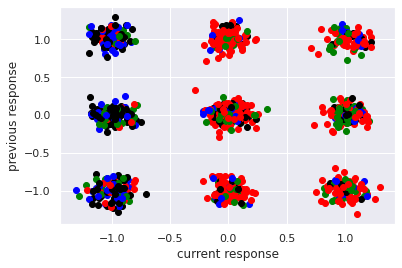

In [120]:
data_plot = all_data[:1000]
# red : most difficulty
# black : least difficulty
colors = ['red', 'green', 'blue', 'yellow', 'black']
for i in range(1000):
  plt.scatter(data_plot.iloc[i]['response'], data_plot.iloc[i]['prev response'], color = colors[int(data_plot.iloc[i]['dif'] * 4)])


plt.xlabel("current response")
plt.ylabel("previous response")


In [ ]:

rep_indexes = []
for i in range(1, dat['response'].size):
  if dat['response'][i] == dat['response'][i - 1]:
    rep_indexes.append(i)

rep_responses = dat['response'][rep_indexes]
feedback_type_rep = dat['feedback_type'][np.array(rep_indexes) - 1]
contrast_left = dat['contrast_left'][np.array(rep_indexes)]
contrast_right = dat['contrast_right'][np.array(rep_indexes)]

difference = (contrast_left - contrast_right)

data = pd.DataFrame(np.column_stack([rep_indexes, rep_responses, feedback_type_rep, contrast_left, contrast_right, difference]), 
             columns = ['num_trial', 'act', 'previous/feedback', 'contrast left', 'contrast right', 'difference'])


data = pd.DataFrame(data.values[np.abs(data.values[:, 5]) <= 0.25], 
             columns = ['num_trial', 'act', 'previous/feedback', 'contrast left', 'contrast right', 'difference'])



In [ ]:
data_stay = []
p = []
for mouse in alldat:
  rep_indexes = []
  for i in range(1, mouse['response'].size):
    if mouse['response'][i] == mouse['response'][i - 1]:
      rep_indexes.append(i)
  

  rep_responses = mouse['response'][rep_indexes]
  feedback_type_rep = mouse['feedback_type'][np.array(rep_indexes) - 1]

  q = np.where(feedback_type_rep == 1)[0].size / np.where(mouse['feedback_type'] == 1)[0].size
  print(np.where(feedback_type_rep == 1)[0].size / rep_responses.size, q)
  data_stay.append(np.column_stack([rep_indexes, rep_responses, feedback_type_rep]))

  print(mouse['mouse_name'] + " done!")



0.5555555555555556 0.28368794326241137
Cori done!
0.625 0.34591194968553457
Cori done!
0.6111111111111112 0.36423841059602646
Cori done!
0.5922330097087378 0.3674698795180723
Forssmann done!
0.6413043478260869 0.35119047619047616
Forssmann done!
0.8068181818181818 0.3302325581395349
Forssmann done!
0.7419354838709677 0.40828402366863903
Forssmann done!
0.5684210526315789 0.33540372670807456
Hench done!
0.66 0.38823529411764707
Hench done!
0.6712328767123288 0.35379061371841153
Hench done!
0.8053097345132744 0.33455882352941174
Hench done!
0.7333333333333333 0.3944223107569721
Lederberg done!
0.8596491228070176 0.4100418410041841
Lederberg done!
0.6666666666666666 0.3225806451612903
Lederberg done!
0.7571428571428571 0.343042071197411
Lederberg done!
0.6666666666666666 0.3681592039800995
Lederberg done!
0.8105263157894737 0.41397849462365593
Lederberg done!
0.7884615384615384 0.3319838056680162
Lederberg done!
0.45348837209302323 0.2746478873239437
Moniz done!
0.5168539325842697 0.33093

In [ ]:
data_stay[9][ : , 2]

array([-1.,  1., -1.,  1.,  1.,  1., -1.,  1.,  1.,  1.,  1.,  1., -1.,
        1.,  1.,  1.,  1., -1.,  1.,  1.,  1., -1., -1.,  1., -1., -1.,
       -1.,  1., -1.,  1., -1., -1.,  1., -1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1., -1.,
        1.,  1.,  1., -1.,  1.,  1.,  1.,  1., -1.,  1.,  1., -1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1., -1.,  1., -1.,  1.,  1., -1., -1.,
        1.,  1., -1., -1., -1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1., -1.,  1.,  1.,  1.,  1.,
       -1.,  1., -1.,  1.,  1.,  1.,  1.,  1.,  1., -1.,  1.,  1.,  1.,
        1.,  1., -1.,  1.,  1., -1., -1., -1.,  1.,  1.,  1., -1.,  1.,
        1., -1., -1., -1., -1., -1., -1.,  1., -1., -1., -1., -1., -1.,
       -1., -1., -1.])

In [ ]:
np.sum(confusion_matrix, axis = 0)
print('reward and stay ' ,np.sum(confusion_matrix, axis = 0)[0,0])
print('punish and stay ' , np.sum(confusion_matrix, axis = 0)[0,1])
print('reward and shift ' , np.sum(confusion_matrix, axis = 0)[1,0])
print('punish and shift ' , np.sum(confusion_matrix, axis = 0)[1,1])

reward and stay  2410.0
punish and stay  1207.0
reward and shift  4512.0
punish and shift  1882.0


In [ ]:
mouse_ind = 2

print(alldat[mouse_ind]['mouse_name'])
print('reward and stay ' , confusion_matrix[mouse_ind][0,0])
print('punish and stay ' , confusion_matrix[mouse_ind][0,1])
print('reward and shift ' , confusion_matrix[mouse_ind][1,0])
print('punish and shift ' , confusion_matrix[mouse_ind][1,1])

Cori
reward and stay  55.0
punish and stay  35.0
reward and shift  96.0
punish and shift  41.0


In [ ]:
confusion_matrix = np.zeros((39, 2, 2))

for i, mouse in enumerate(alldat):
  confusion_matrix[i, 0, 0] = np.where(data_stay[i][ : , 2] == 1)[0].size
  confusion_matrix[i, 0, 1] = np.where(data_stay[i][ : , 2] == -1)[0].size
  confusion_matrix[i, 1, 0] = np.where(data_shift[i][ : , 2] == 1)[0].size
  confusion_matrix[i, 1, 1] = np.where(data_shift[i][ : , 2] == -1)[0].size




In [ ]:
data_shift = []
for mouse in alldat:
  rep_indexes = []
  for i in range(1, mouse['response'].size):
    if mouse['response'][i] != mouse['response'][i - 1]:
      rep_indexes.append(i)
    
      

  rep_responses = mouse['response'][rep_indexes]
  feedback_type_rep = mouse['feedback_type'][np.array(rep_indexes) - 1]
  print(np.where(feedback_type_rep == -1)[0].size / np.where(mouse['feedback_type'] == -1)[0].size)
  data_shift.append(np.column_stack([rep_indexes, rep_responses, feedback_type_rep]))

  print(mouse['mouse_name'] + " done!")



0.547945205479452
Cori done!
0.6304347826086957
Cori done!
0.5324675324675324
Cori done!
0.4819277108433735
Forssmann done!
0.6046511627906976
Forssmann done!
0.7733333333333333
Forssmann done!
0.6987951807228916
Forssmann done!
0.5280898876404494
Hench done!
0.5555555555555556
Hench done!
0.711764705882353
Hench done!
0.6714285714285714
Hench done!
0.5842696629213483
Lederberg done!
0.7213114754098361
Lederberg done!
0.6219512195121951
Lederberg done!
0.631578947368421
Lederberg done!
0.5189873417721519
Lederberg done!
0.5
Lederberg done!
0.6666666666666666
Lederberg done!
0.5428571428571428
Moniz done!
0.5416666666666666
Moniz done!
0.46551724137931033
Moniz done!
0.7819548872180451
Muller done!
0.40816326530612246
Muller done!
0.6153846153846154
Muller done!
0.6301369863013698
Radnitz done!
0.5208333333333334
Radnitz done!
0.7021276595744681
Radnitz done!
0.5087719298245614
Radnitz done!
0.3584905660377358
Radnitz done!
0.4788732394366197
Richards done!
0.6438356164383562
Richards d

`alldat` contains 39 sessions from 10 mice, data from Steinmetz et al, 2019. Time bins for all measurements are 10ms, starting 500ms before stimulus onset. The mouse had to determine which side has the highest contrast. For each `dat = alldat[k]`, you have the following fields:

* `dat['mouse_name']`: mouse name
* `dat['date_exp']`: when a session was performed
* `dat['spks']`: neurons by trials by time bins.    
* `dat['brain_area']`: brain area for each neuron recorded. 
* `dat['contrast_right']`: contrast level for the right stimulus, which is always contralateral to the recorded brain areas.
* `dat['contrast_left']`: contrast level for left stimulus. 
* `dat['gocue']`: when the go cue sound was played. 
* `dat['response_times']`: when the response was registered, which has to be after the go cue. The mouse can turn the wheel before the go cue (and nearly always does!), but the stimulus on the screen won't move before the go cue.  
* `dat['response']`: which side the response was (`-1`, `0`, `1`). When the right-side stimulus had higher contrast, the correct choice was `-1`. `0` is a no go response. 
* `dat['feedback_time']`: when feedback was provided. 
* `dat['feedback_type']`: if the feedback was positive (`+1`, reward) or negative (`-1`, white noise burst).  
* `dat['wheel']`: exact position of the wheel that the mice uses to make a response, binned at `10ms`. 
* `dat['pupil']`: pupil area  (noisy, because pupil is very small) + pupil horizontal and vertical position. 
* `dat['lfp']`: recording of the local field potential in each brain area from this experiment, binned at `10ms`.
* `dat['brain_area_lfp']`: brain area names for the LFP channels. 
* `dat['trough_to_peak']`: measures the width of the action potential waveform for each neuron. Widths `<=10` samples are "putative fast spiking neurons". 
* `dat['waveform_w']`: temporal components of spike waveforms. `w@u` reconstructs the time by channels action potential shape. 
* `dat['waveform_u]`: spatial components of spike waveforms.
* `dat['%X%_passive']`: same as above for `X` = {`spks`, `lfp`, `pupil`, `wheel`, `contrast_left`, `contrast_right`} but for  passive trials at the end of the recording when the mouse was no longer engaged and stopped making responses. 




In [ ]:

dat['contrast_right'] > dat['contrast_left']

array([False, False, False, False,  True, False,  True,  True, False,
        True,  True,  True, False, False, False, False, False, False,
       False, False,  True, False, False,  True,  True, False, False,
       False, False, False, False, False, False, False, False, False,
        True, False, False, False,  True, False, False,  True,  True,
       False, False,  True, False,  True,  True, False, False,  True,
        True, False, False,  True,  True, False, False, False,  True,
       False, False,  True,  True, False, False, False, False, False,
       False,  True, False, False, False, False,  True, False, False,
       False, False, False, False,  True, False, False, False, False,
        True, False, False, False, False, False, False,  True, False,
       False,  True,  True,  True, False, False, False, False, False,
       False, False, False,  True, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False,

In [ ]:
#@title import matplotlib and set defaults
from matplotlib import rcParams 
from matplotlib import pyplot as plt
rcParams['figure.figsize'] = [20, 4]
rcParams['font.size'] =15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

In [ ]:
 np.arange(NT)

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

(250,)


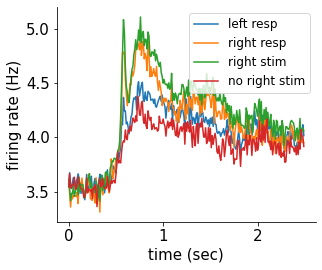

In [ ]:
#@title basic plots of population average
from matplotlib import pyplot as plt
dt = dat['bin_size'] # binning at 10 ms
NT = dat['spks'].shape[-1]

ax = plt.subplot(1,5,1)
response = dat['response'] # right - nogo - left (-1, 0, 1)
vis_right = dat['contrast_right'] # 0 - low - high
vis_left = dat['contrast_left'] # 0 - low - high
plt.plot(dt * np.arange(NT), 1/dt * dat['spks'][:,response>=0].mean(axis=(0,1))) # left responses
plt.plot(dt * np.arange(NT), 1/dt * dat['spks'][:,response<0].mean(axis=(0,1))) # right responses
plt.plot(dt * np.arange(NT), 1/dt * dat['spks'][:,vis_right>0].mean(axis=(0,1))) # stimulus on the right
plt.plot(dt * np.arange(NT), 1/dt * dat['spks'][:,vis_right==0].mean(axis=(0,1))) # no stimulus on the right
print(dat['spks'][:,response>=0].mean(axis=(0,1)).shape)
plt.legend(['left resp', 'right resp', 'right stim', 'no right stim'], fontsize=12)
ax.set(xlabel  = 'time (sec)', ylabel = 'firing rate (Hz)');

In [ ]:
# groupings of brain regions
regions = ["vis ctx", "thal", "hipp", "other ctx", "midbrain", "basal ganglia", "cortical subplate", "other"]
brain_groups = [["VISa", "VISam", "VISl", "VISp", "VISpm", "VISrl"], # visual cortex
                ["CL", "LD", "LGd", "LH", "LP", "MD", "MG", "PO", "POL", "PT", "RT", "SPF", "TH", "VAL", "VPL", "VPM"], # thalamus
                ["CA", "CA1", "CA2", "CA3", "DG", "SUB", "POST"], # hippocampal
                ["ACA", "AUD", "COA", "DP", "ILA", "MOp", "MOs", "OLF", "ORB", "ORBm", "PIR", "PL", "SSp", "SSs", "RSP"," TT"], # non-visual cortex
                ["APN", "IC", "MB", "MRN", "NB", "PAG", "RN", "SCs", "SCm", "SCig", "SCsg", "ZI"], # midbrain
                ["ACB", "CP", "GPe", "LS", "LSc", "LSr", "MS", "OT", "SNr", "SI"], # basal ganglia 
                ["BLA", "BMA", "EP", "EPd", "MEA"] # cortical subplate
                ]

nareas = 4 # only the top 4 regions are in this particular mouse
NN = len(dat['brain_area']) # number of neurons
barea = nareas * np.ones(NN, ) # last one is "other"
for j in range(nareas):
  barea[np.isin(dat['brain_area'], brain_groups[j])] = j # assign a number to each region

In [ ]:
dat['wheel']

array([[[ 0.,  0., -1., ...,  0.,  0.,  0.],
        [-1., -1., -1., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ...,
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ..., -2., -2., -2.]]])

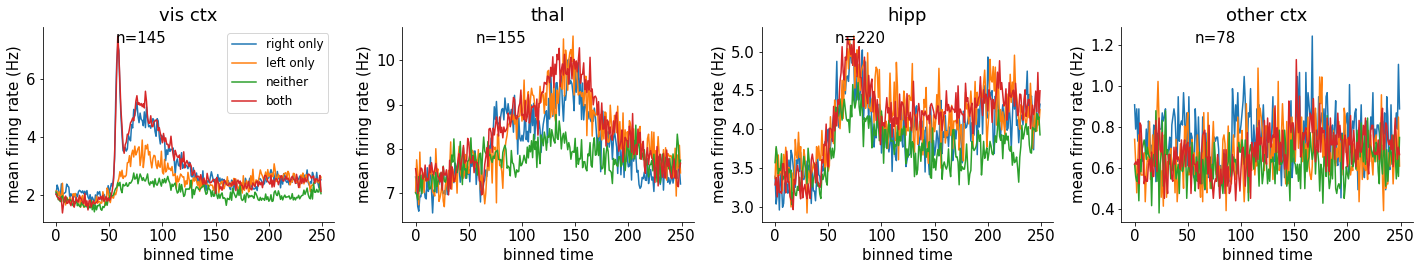

In [ ]:
#@title plots by brain region and visual conditions
for j in range(nareas):
  ax = plt.subplot(1,nareas,j+1)
  
  plt.plot(1/dt *  dat['spks'][barea==j][:,np.logical_and(vis_left==0, vis_right>0)].mean(axis=(0,1)))
  plt.plot(1/dt *  dat['spks'][barea==j][:,np.logical_and(vis_left>0 , vis_right==0)].mean(axis=(0,1)))
  plt.plot(1/dt *  dat['spks'][barea==j][:,np.logical_and(vis_left==0 , vis_right==0)].mean(axis=(0,1)))
  plt.plot(1/dt *  dat['spks'][barea==j][:,np.logical_and(vis_left>0, vis_right>0)].mean(axis=(0,1)))  
  plt.text(.25, .92, 'n=%d'%np.sum(barea==j), transform=ax.transAxes)
 
  if j==0:
    plt.legend(['right only', 'left only', 'neither', 'both'], fontsize=12)
  ax.set(xlabel = 'binned time', ylabel = 'mean firing rate (Hz)', title = regions[j])


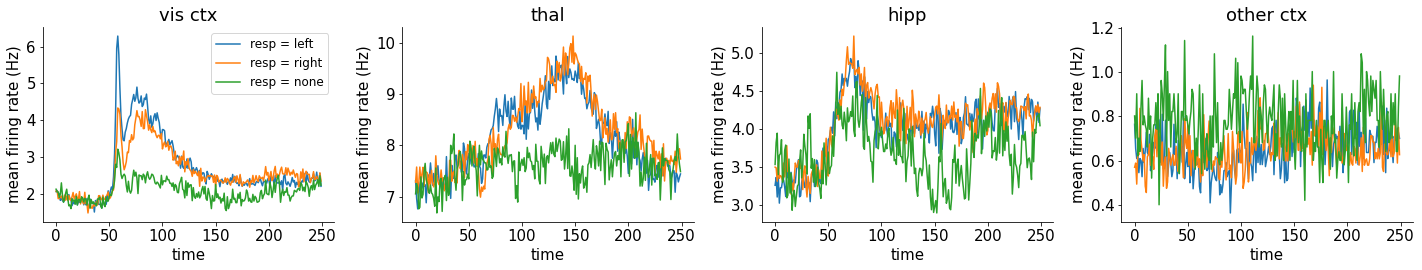

In [ ]:
#@title plots by brain region and response type
for j in range(nareas):
  ax = plt.subplot(1,nareas,j+1)
  plt.title(regions[j])
  if np.sum(barea==j)==0:
    continue
  plt.plot(1/dt * dat['spks'][barea==j][:,response<0].mean(axis=(0,1)))  
  plt.plot(1/dt * dat['spks'][barea==j][:,response>0].mean(axis=(0,1)))
  plt.plot(1/dt * dat['spks'][barea==j][:,response==0].mean(axis=(0,1)))
 
  if j==0:
    plt.legend(['resp = left', 'resp = right', 'resp = none'], fontsize=12)
  ax.set(xlabel = 'time', ylabel = 'mean firing rate (Hz)')


In [ ]:
#@title top PC directions from stimulus + response period, with projections of the entire duration
from sklearn.decomposition import PCA 

droll = np.reshape(dat['spks'][:,:,51:130], (NN,-1)) # first 80 bins = 1.6 sec
droll = droll - np.mean(droll, axis=1)[:, np.newaxis]
model = PCA(n_components = 5).fit(droll.T)
W = model.components_
pc_10ms = W @ np.reshape(dat['spks'], (NN,-1))
pc_10ms = np.reshape(pc_10ms, (5, -1, NT))

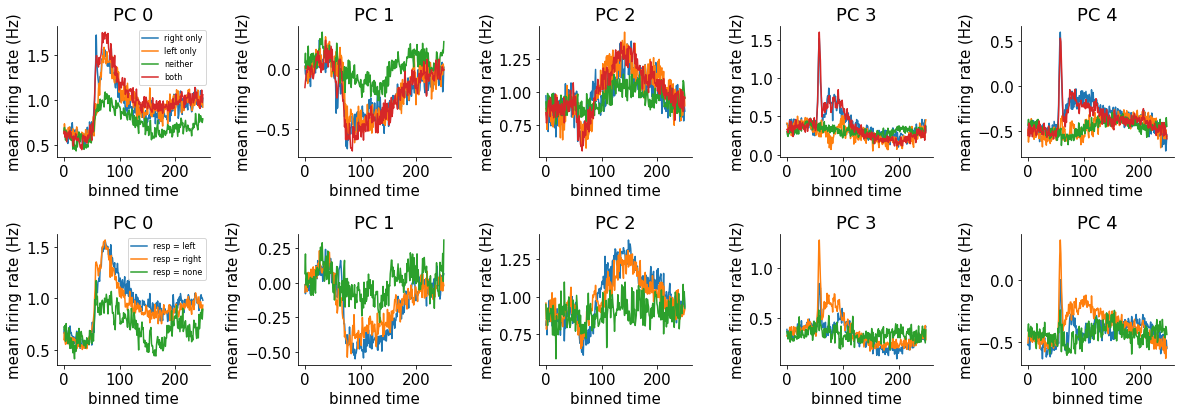

In [ ]:
#@title The top PCs capture most variance across the brain. What do they care about? 
plt.figure(figsize= (20, 6))
for j in range(len(pc_10ms)):
  ax = plt.subplot(2,len(pc_10ms)+1,j+1)
  pc1 = pc_10ms[j]

  plt.plot(pc1[np.logical_and(vis_left==0, vis_right>0), :].mean(axis=0))  
  plt.plot(pc1[np.logical_and(vis_left>0, vis_right==0), :].mean(axis=0))
  plt.plot(pc1[np.logical_and(vis_left==0, vis_right==0), :].mean(axis=0))
  plt.plot(pc1[np.logical_and(vis_left>0, vis_right>0), :].mean(axis=0))
   
  if j==0:
    plt.legend(['right only', 'left only', 'neither', 'both'], fontsize=8)
  ax.set(xlabel = 'binned time', ylabel = 'mean firing rate (Hz)')
  plt.title('PC %d'%j)

  ax = plt.subplot(2,len(pc_10ms)+1,len(pc_10ms)+1 + j+1)
  
  plt.plot(pc1[response>0, :].mean(axis=0))  
  plt.plot(pc1[response<0, :].mean(axis=0))
  plt.plot(pc1[response==0, :].mean(axis=0))

  if j==0:
    plt.legend(['resp = left', 'resp = right', 'resp = none'], fontsize=8)
  ax.set(xlabel = 'binned time', ylabel = 'mean firing rate (Hz)')
  plt.title('PC %d'%j)

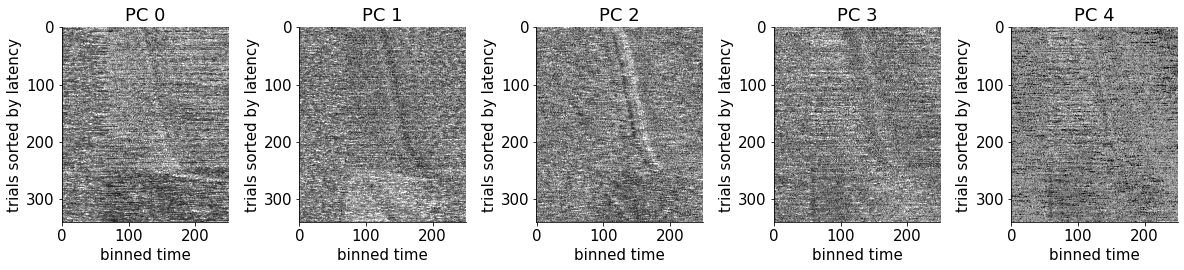

In [ ]:
#@title now sort all trials by response latency and see if the PCs care about that.
from scipy.stats import zscore

isort = np.argsort(dat['response_time'].flatten())

for j in range(len(pc_10ms)):
  ax = plt.subplot(1,len(pc_10ms)+1,j+1)
  pc1 = zscore(pc_10ms[j])
  plt.imshow(pc1[isort, :], aspect='auto', vmax=2, vmin = -2, cmap = 'gray')
  ax.set(xlabel = 'binned time', ylabel = 'trials sorted by latency')
  plt.title('PC %d'%j)

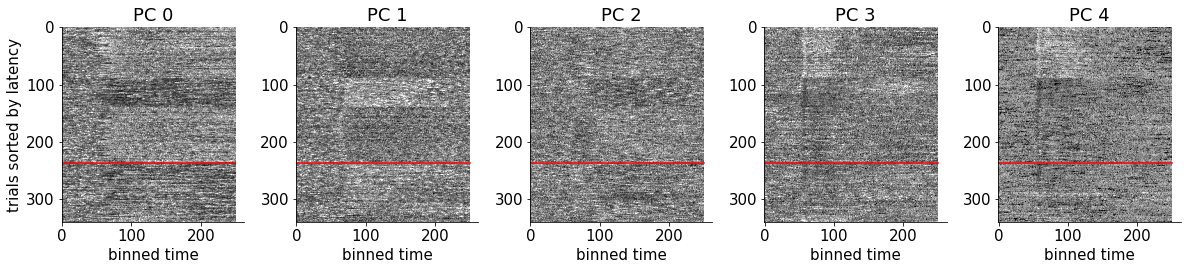

In [ ]:
#@title correct vs incorrect trials
# the following are the correct responses:
# if vis_left > vis_right : response >0
# if vis_left < vis_right : response <0
# if vis_left = vis_right : response =0
# trials below red line are incorrect
is_correct = np.sign(response)==np.sign(vis_left-vis_right)

# sort by correct, and then by response
isort = np.argsort(-is_correct.astype('float32') + response/10) 

nwrong = np.sum(is_correct)
for j in range(len(pc_10ms)):
  ax = plt.subplot(1,len(pc_10ms)+1,j+1)
  pc1 = zscore(pc_10ms[j])
  plt.imshow(pc1[isort, :], aspect='auto', vmax=2, vmin = -2, cmap = 'gray')
  ax.set(xlabel = 'binned time')
  if j==0:
    ax.set(ylabel = 'trials sorted by latency')  
  plt.title('PC %d'%j)

  plt.plot([0, NT], [nwrong, nwrong], 'r')


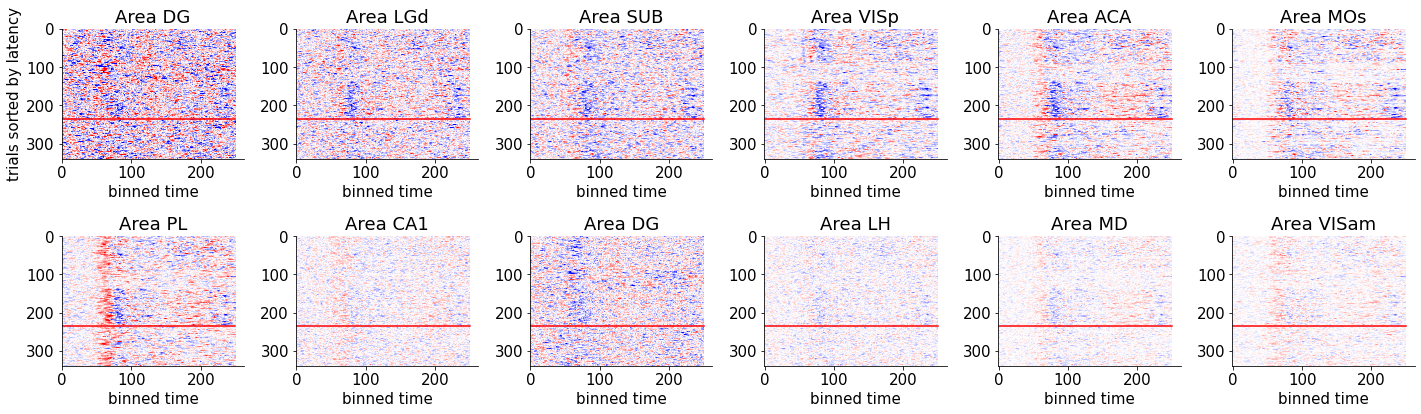

In [ ]:
# plot the LFP

is_correct = np.sign(response)==np.sign(vis_left-vis_right)
isort = np.argsort(-is_correct.astype('float32') + response/10) # sort by correct, and then by response

nwrong = np.sum(is_correct)
plt.figure(figsize=(20,6))
for j in range(len(dat['lfp'])):
  ax = plt.subplot(2,6,j+1)
  plt.imshow(dat['lfp'][j, isort], cmap = 'bwr', vmax = 50, vmin=-50, aspect='auto')
  plt.title('Area %s'%dat['brain_area_lfp'][j])
  
  plt.plot([0, NT], [nwrong, nwrong], 'r')
  ax.set(xlabel = 'binned time')
  if j==0:
    ax.set(ylabel = 'trials sorted by latency')  


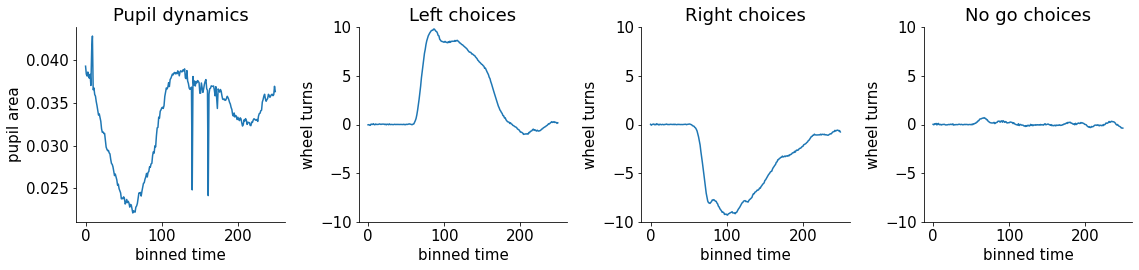

In [ ]:
# plot the behavioral data (pupil area is noisy because it's very small)

ax = plt.subplot(1,5,1)
plt.plot(dat['pupil'][0, :].mean(0));
ax.set(ylabel='pupil area', xlabel = 'binned time', title='Pupil dynamics')

yl = [-10, 10]
ax = plt.subplot(1,5,2)
plt.plot(dat['wheel'][0, response>0].mean(0));
ax.set(ylim=yl)
ax.set(ylim=yl, ylabel='wheel turns', xlabel = 'binned time', title='Left choices');

ax = plt.subplot(1,5,3)
plt.plot(dat['wheel'][0, response<0].mean(0));
ax.set(ylim=yl)
ax.set(ylim=yl, ylabel='wheel turns', xlabel = 'binned time', title='Right choices');

ax = plt.subplot(1,5,4)
plt.plot(dat['wheel'][0, response==0].mean(0));
ax.set(ylim=yl, ylabel='wheel turns', xlabel = 'binned time', title='No go choices');


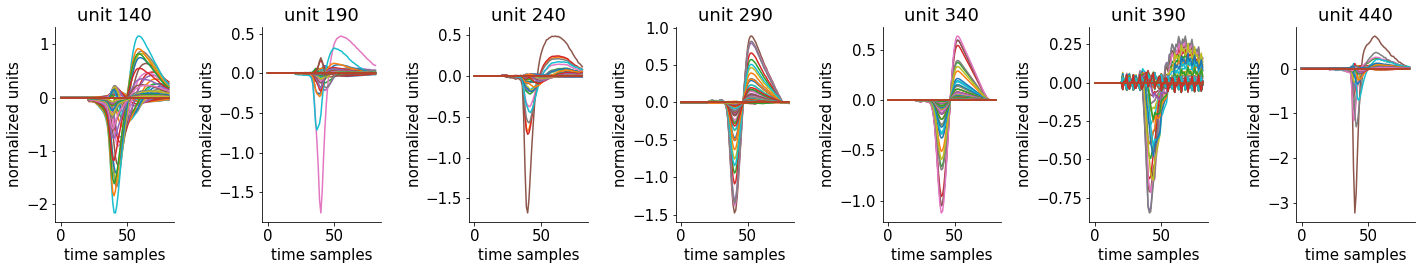

In [ ]:
# plot the spike waveforms for some neurons. Sometimes these can tell us what cell type the neuron is 
# (i.e. fast spiking interneurons have short waveforms)

for j in range(7):
  ax = plt.subplot(1,7,j+1)
  kk = 140 + j * 50
  wav = dat['waveform_w'][kk] @ dat['waveform_u'][kk]
  plt.plot(wav)
  ax.set(xlabel = 'time samples', title ='unit %d'%kk, ylabel = 'normalized units')

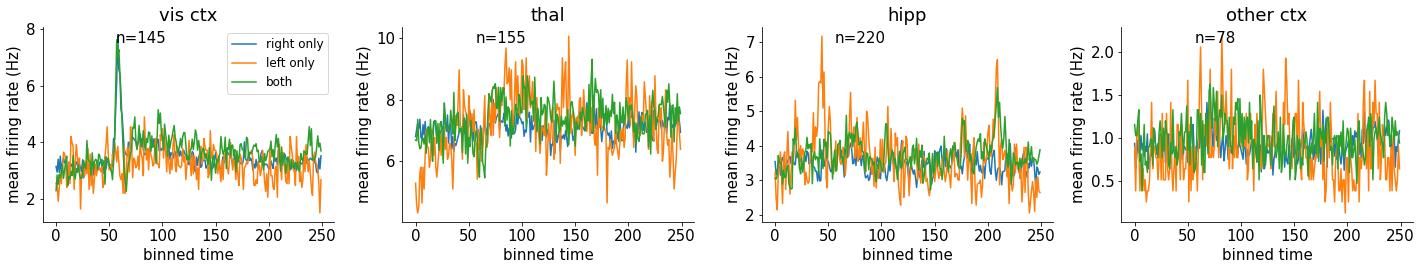

In [ ]:
# plots by brain region and visual conditions for PASSIVE trials
vis_left_p = dat['contrast_left_passive']
vis_right_p = dat['contrast_right_passive']
for j in range(nareas):
  ax = plt.subplot(1,nareas,j+1)
  plt.title(regions[j])
  
  plt.plot(1/dt *  dat['spks_passive'][barea==j][:,np.logical_and(vis_left_p==0, vis_right_p>0)].mean(axis=(0,1)))
  plt.plot(1/dt *  dat['spks_passive'][barea==j][:,np.logical_and(vis_left_p>0 , vis_right_p==0)].mean(axis=(0,1)))
  #plt.plot(1/dt *  dat['spks_passive'][barea==j][:,np.logical_and(vis_left_p==0 , vis_right_p==0)].mean(axis=(0,1)))
  plt.plot(1/dt *  dat['spks_passive'][barea==j][:,np.logical_and(vis_left_p>0, vis_right_p>0)].mean(axis=(0,1)))  
  plt.text(.25, .92, 'n=%d'%np.sum(barea==j), transform=ax.transAxes)
 
  if j==0:
    plt.legend(['right only', 'left only', 'both'], fontsize=12)
  ax.set(xlabel = 'binned time', ylabel = 'mean firing rate (Hz)')